In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1*3)



**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.098E+00
    # of points  =    5677
    # of edges   =   16908
    # of cells   =   11232
    # of boundary points =     120
    # of boundary edges  =     120
    # of boundary cells  =     120
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  3.455E-02
    hmax =  1.152E-01
  Surface grounded at vertex    1537


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.6750000000000001E-003


In [5]:
delta = -0.5
fix_xloc = False  #maintains location of x-points when changing triangularity by modifying inner/outer midplane gaps

In [6]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Constrain CS current
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,1] = -1

targets[0] = -3E6

coil_weights[:3] = 5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

In [7]:
#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11

#turn off div coils, for now
#coil_bounds[-5:-1, 0] = -122448.979592
#coil_bounds[-5:-1, 1] = 122448.979592
coil_bounds[-5:-1, 0] = 0 
coil_bounds[-5:-1, 1] = 0

mygs.set_coil_bounds(coil_bounds)

In [8]:
# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25

ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [9]:
# set global targets
Ip_target = 0.75E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

In [10]:
# set boundary/saddle point/strike point targets
if fix_xloc:
    d0 = -0.5
    if delta<d0:
        boundary = create_isoflux(4,1+0.2588*((1-d0)/(1-delta)-1),0.0,0.2588*(1-d0)/(1-delta),1.7*(1-delta)/(1-d0),delta)
    else:
        boundary = create_isoflux(4,1+0.2588*(1-(1+d0)/(1+delta)),0.0,0.2588*(1+d0)/(1+delta),1.7*(1+delta)/(1+d0),delta)
else:
    boundary = create_isoflux(4,1,0.0,0.2588,1.7,delta)



x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

strike_ul = [1.06, 0.55]
strike_ur = [1.255, 0.495]

strike_ll = np.copy(strike_ul)
strike_ll[1] = -strike_ul[1]
strike_lr = np.copy(strike_ur)
strike_lr[1] = -strike_ur[1]

#boundary = np.vstack((boundary, strike_ul, strike_ll, strike_lr, strike_ur))
isoflux_weights = 50*np.ones(len(boundary))
#isoflux_weights[-4:] = 500

mygs.set_isoflux(boundary, isoflux_weights)

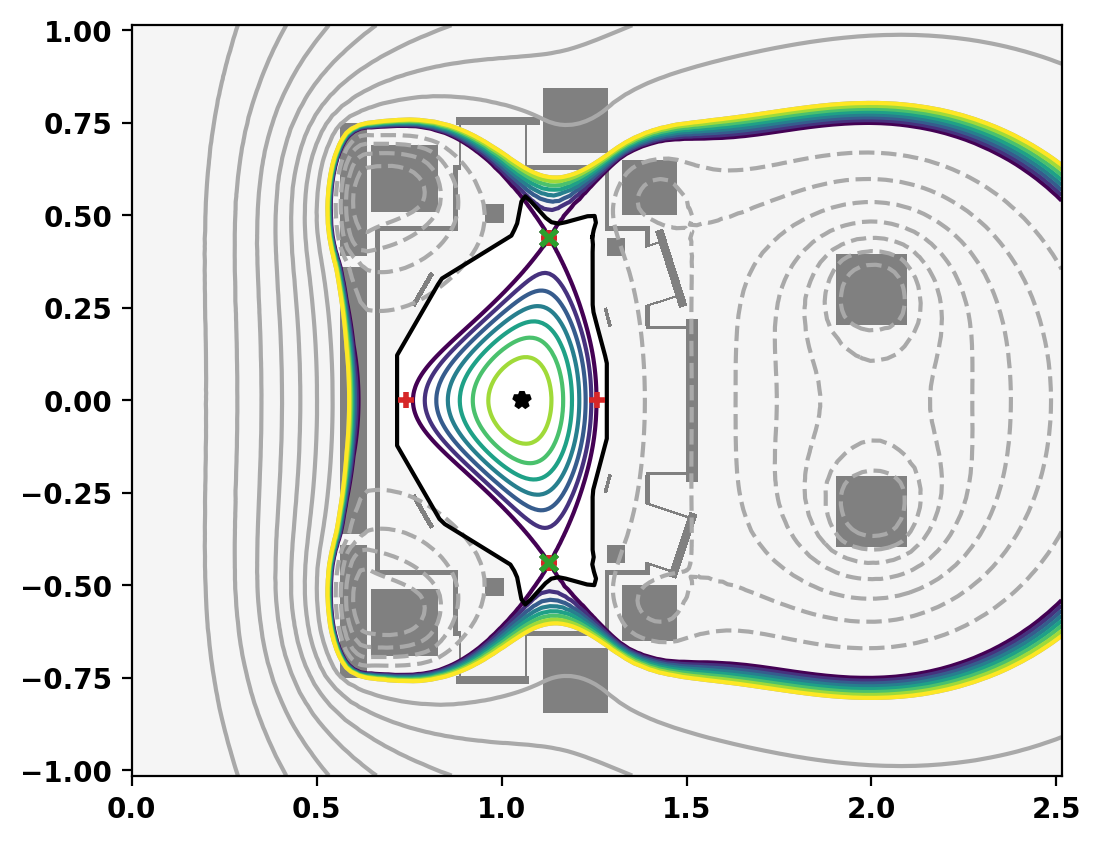

In [11]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [12]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  6.7764E+00  3.0980E+00  3.2066E-02  1.0499E+00 -3.0614E-05 -0.0000E+00
     2  6.4881E+00  3.0196E+00  5.7690E-03  1.0470E+00 -5.3909E-06 -0.0000E+00
     3  6.3500E+00  2.9753E+00  8.9584E-04  1.0454E+00  8.8110E-06 -0.0000E+00
     4  6.2877E+00  2.9546E+00  3.6197E-04  1.0445E+00 -1.5736E-05 -0.0000E+00
     5  6.2599E+00  2.9451E+00  2.2226E-04  1.0442E+00 -1.4507E-05 -0.0000E+00
     6  6.2476E+00  2.9409E+00  1.1659E-04  1.0440E+00 -1.3952E-05 -0.0000E+00
     7  6.2422E+00  2.9390E+00  5.6094E-05  1.0439E+00 -1.3700E-05 -0.0000E+00
     8  6.2399E+00  2.9382E+00  2.5757E-05  1.0439E+00 -1.3584E-05 -0.0000E+00
     9  6.2389E+00  2.9378E+00  1.1481E-05  1.0438E+00 -1.3530E-05 -0.0000E+00
    10  6.2385E+00  2.9377E+00  5.0071E-06  1.0438E+00 -1.3506E-05 -0.0000E+00
    11  6.2384E+00  2.9376E+00  2.1453E-06  1.0438E+00 -1.3495E-05 -0.0000E+00
    12  6.2383E+00  2.9376E+00  9.0492E-07  1.0438E+00 -1.3490E-05 -0.0000E+00
 Timing:  0.1583300000

0

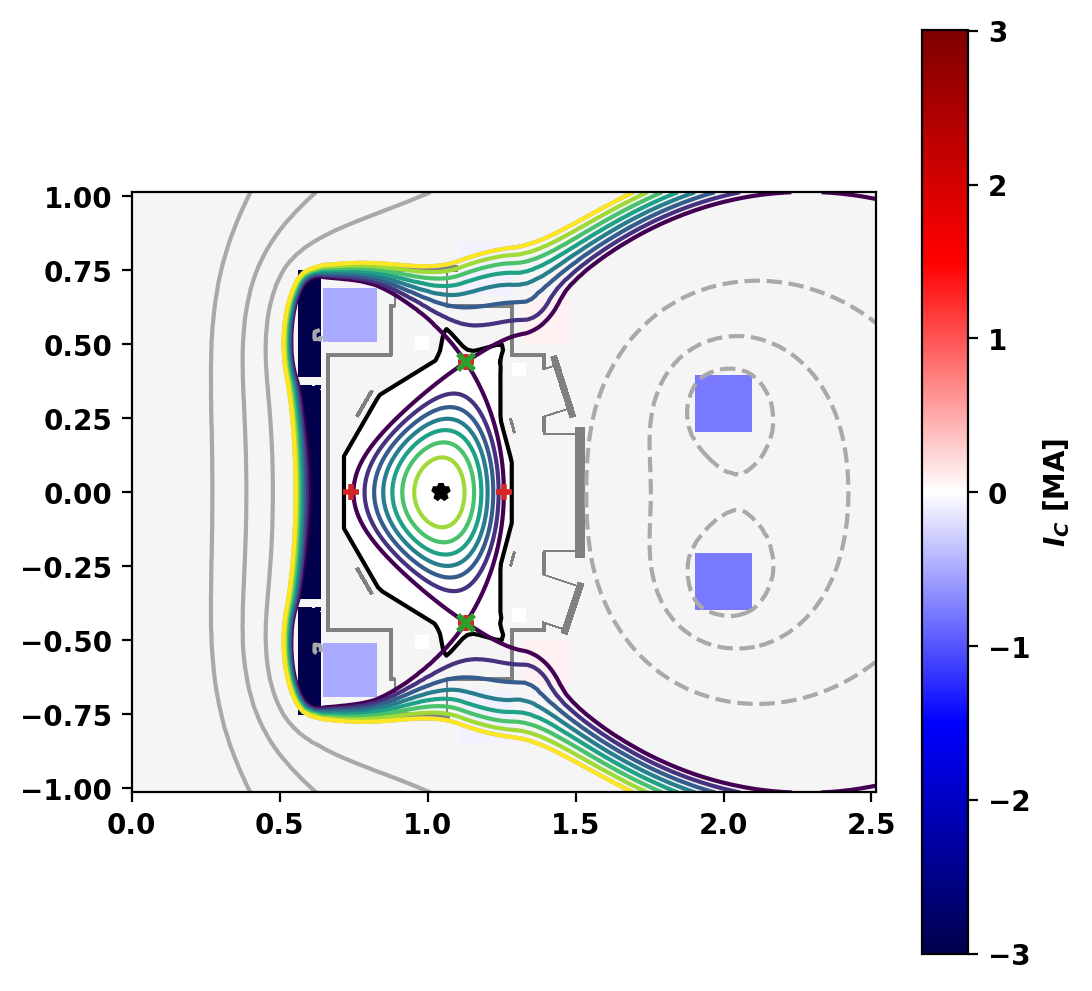

In [13]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)




In [14]:
mygs.print_info()

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    7.5000E+05
  Current Centroid [m]    =    1.035  0.000
  Magnetic Axis [m]       =    1.044 -0.000
  Elongation              =    1.690 (U:  1.747, L:  1.632)
  Triangularity           =   -0.471 (U: -0.495, L: -0.447)
  Plasma Volume [m^3]     =    1.878
  q_0, q_95               =    0.982  2.173
  Peak Pressure [Pa]      =    1.5165E+05
  Stored Energy [J]       =    1.2371E+05
  <Beta_pol> [%]          =   51.9407
  <Beta_tor> [%]          =    1.3147
  Diamagnetic flux [Wb]   =    5.4209E-03
  Toroidal flux [Wb]      =    8.5527E-01
  l_i                     =    0.9416


Starting CG solver
     0  0.000000E+00  0.000000E+00  3.616130E+00
     1 -2.253521E+05  1.429201E+05  8.016585E-01  5.609137E-06
     2 -2.341621E+05  1.527092E+05  3.580175E-01  2.344439E-06
     3 -2.355121E+05  1.544673E+05  1.364949E-01  8.836491E-07
     4 -2.356482E+05  1.550402E+05  4.964418E-02  3.202020E-07
     5 -2.356634E+05  1.549121E+05  2.054291E-02  1.326102E-07
     6 -2.356654E+05  1.549142E+05  8.491227E-03  5.481244E-08
     7 -2.356658E+05  1.549114E+05  3.105581E-03  2.004746E-08
     8 -2.356659E+05  1.549160E+05  1.171006E-03  7.558973E-09
     9 -2.356659E+05  1.549169E+05  4.493269E-04  2.900439E-09
    10 -2.356659E+05  1.549172E+05  1.767218E-04  1.140750E-09
    20 -2.356659E+05  1.549170E+05  1.256929E-08  8.113563E-14
Growth rate = 5.3746E+02 [s^-1]
Growth time = 1.8606E-03 [s]


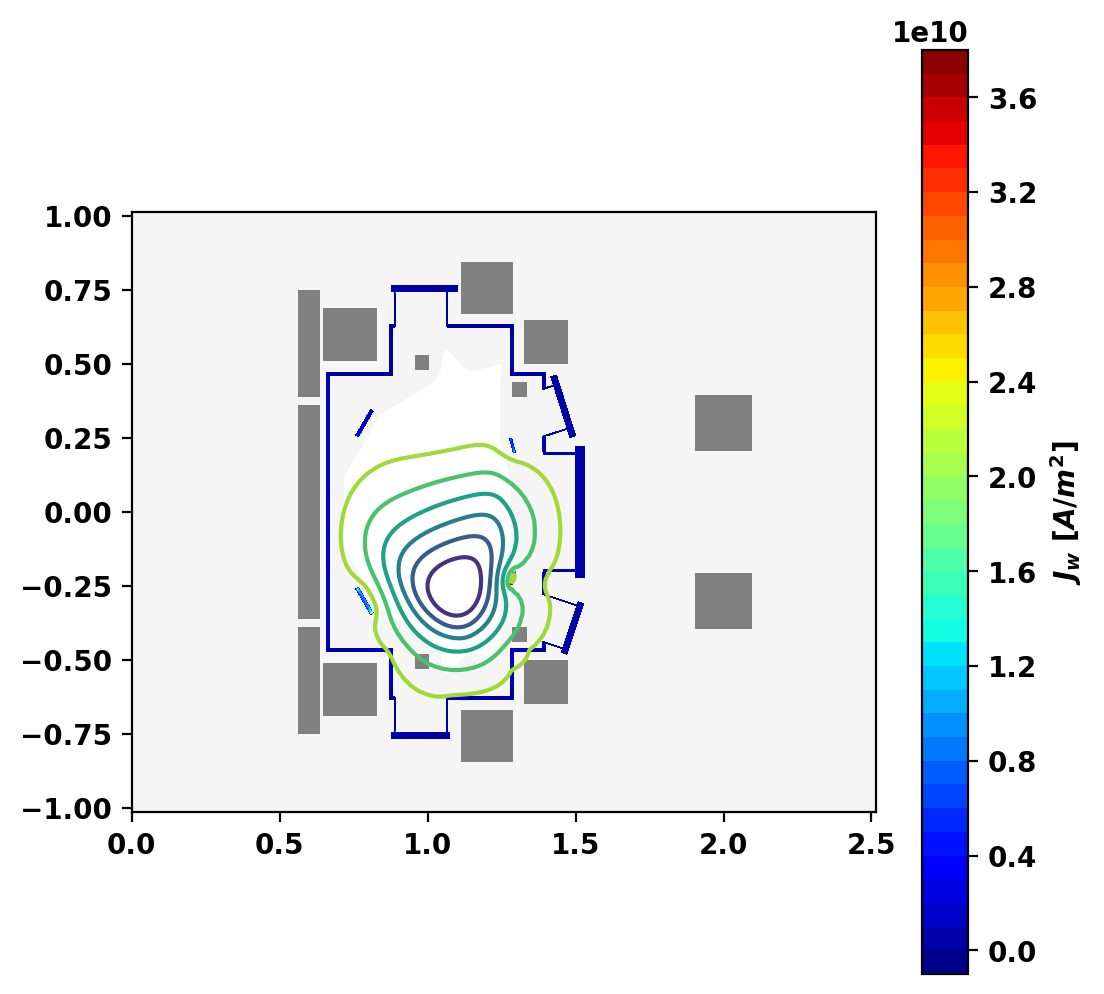

In [15]:
eig_vals, eig_vecs = mygs.eig_td(-5.E3,10,True) 
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],normalized=False,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,-eig_vecs[0,:]*eig_vals[0,0])
print('Growth rate = {0:.4E} [s^-1]'.format(-eig_vals[0,0]))
print('Growth time = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))

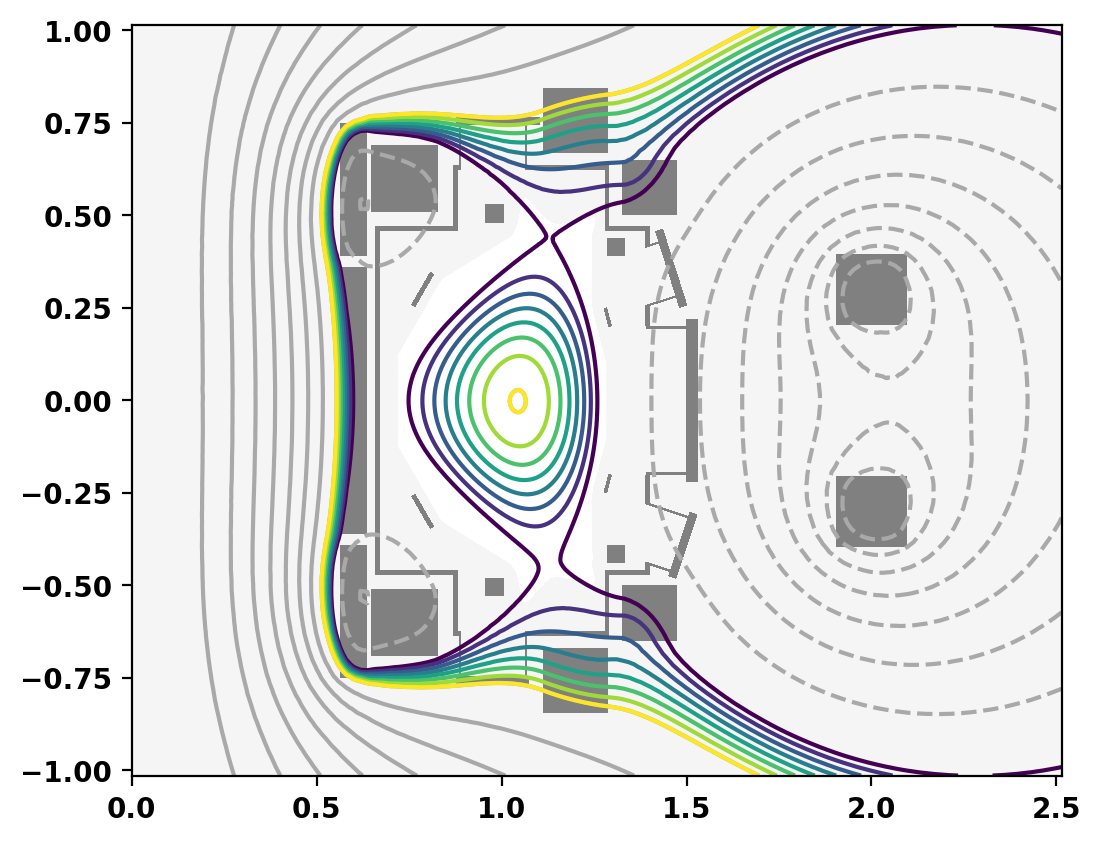

In [16]:
psi0 = mygs.get_psi(normalized = False)
max_loc = abs(eig_vecs[0,:]).argmax()
psi_ic = psi0+eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[0,max_loc]/50

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,(psi_ic-mygs.psi_bounds[1])/(mygs.psi_bounds[0]-mygs.psi_bounds[1]),xpoint_color=None,opoint_color=None)
mygs.set_psi(psi_ic)

In [17]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.set_targets(Ip=0.75E6,Ip_ratio=1)
mygs.setup_td(1.E-03,1.E-13,1.E-11,pre_plasma=False)

In [18]:
import time
sim_time = 0.0
dt = 1.E-1/-eig_vals[0,0]
nplot = 1
nstatus = 1
results = [mygs.get_psi()]
results_raw = [mygs.get_psi(False)]
z0 = [[sim_time,mygs.o_point[1]],]
eig_comp = [[sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)],]
t00 = time.perf_counter()
q_95 = []
gammas = []

for i in range(60):
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()
    if i % nstatus == 0:
        print('{0:.5E} {1:.5E} {2:4d} {3:4d} {5:8.3f} {4:4d}'.format(sim_time,dt,nl_its,lin_its,nretry,t1-t0))
    z0.append([sim_time,mygs.o_point[1]])
    eig_comp.append([sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)])
    q_prof = mygs.get_q()
    if i % nplot == 0:
        results.append(mygs.get_psi())
        results_raw.append(mygs.get_psi(False))
        psi,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi = 0.95)
        eig_vals, eig_vecs = mygs.eig_td(-5.E3,3,True) 
        gammas.append(-eig_vals[0,0])
        q_95.append(qvals[0])
t1 = time.perf_counter()
print('Total time = {0:8.3f}'.format(t1-t00))

1.86062E-04 1.86062E-04    2   17    0.412    0
3.72123E-04 1.86062E-04    2   13    0.153    0
5.58185E-04 1.86062E-04    2   12    0.144    0
7.44247E-04 1.86062E-04    2   14    0.172    0
9.30308E-04 1.86062E-04    2   14    0.170    0
1.11637E-03 1.86062E-04    2   14    0.167    0
1.30243E-03 1.86062E-04    2   14    0.166    0
1.48849E-03 1.86062E-04    2   15    0.253    0
1.67456E-03 1.86062E-04    2   15    0.181    0
1.86062E-03 1.86062E-04    2   15    0.309    0
2.04668E-03 1.86062E-04    2   15    0.186    0
2.23274E-03 1.86062E-04    2   16    0.190    0
2.41880E-03 1.86062E-04    2   15    0.286    0
2.60486E-03 1.86062E-04    2   15    0.170    0
2.79093E-03 1.86062E-04    2   16    0.235    0
2.97699E-03 1.86062E-04    2   16    0.392    0
3.16305E-03 1.86062E-04    2   16    0.180    0
3.34911E-03 1.86062E-04    2   15    0.178    0
3.53517E-03 1.86062E-04    2   15    0.168    0
3.72123E-03 1.86062E-04    2   16    0.176    0
3.90730E-03 1.86062E-04    2   16    0.1

Text(0, 0.5, '$\\mathrm{q}_{95}$')

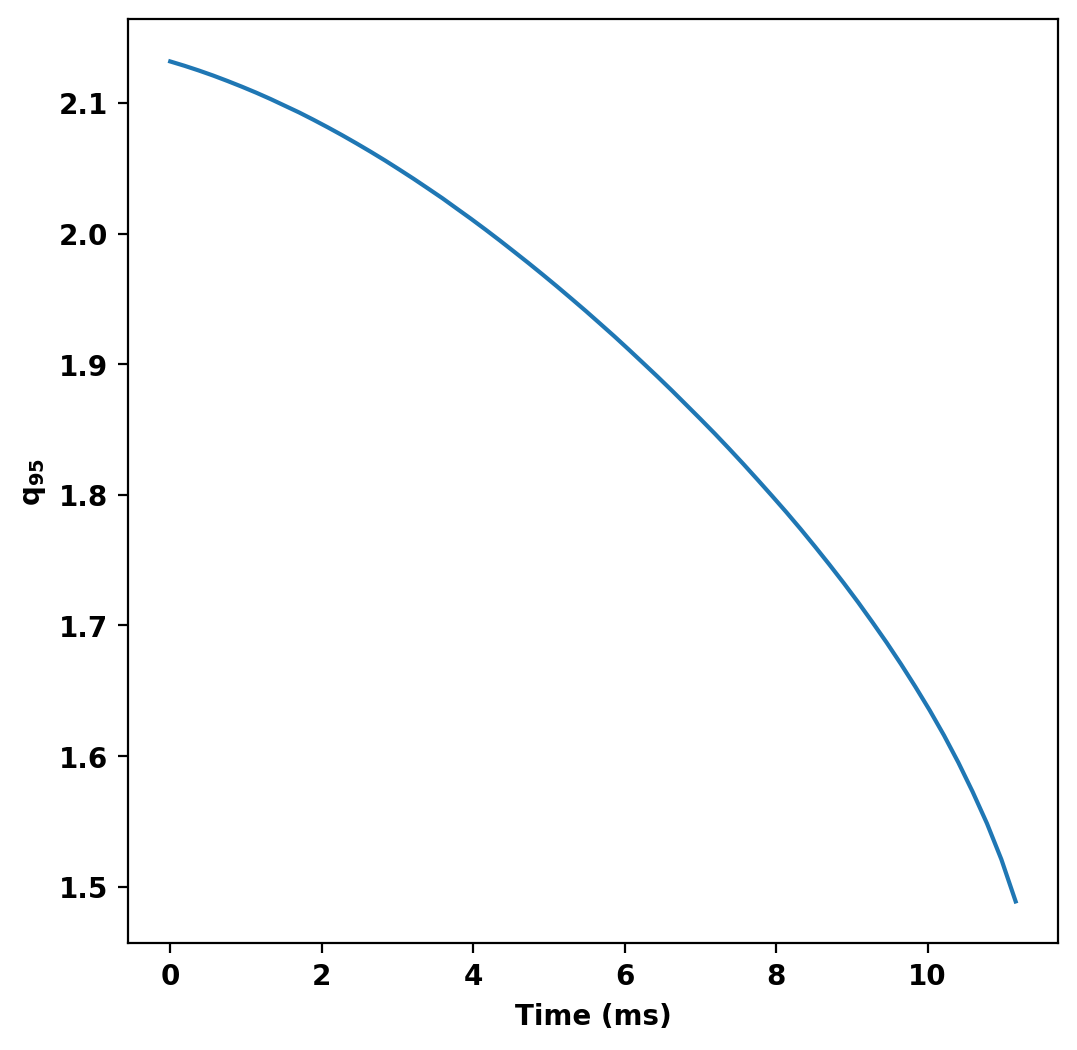

In [19]:
plt.plot(np.linspace(0,sim_time*1000, len(q_95)), q_95)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\mathrm{q}_{95}$')

Text(0, 0.5, '$\\gamma$')

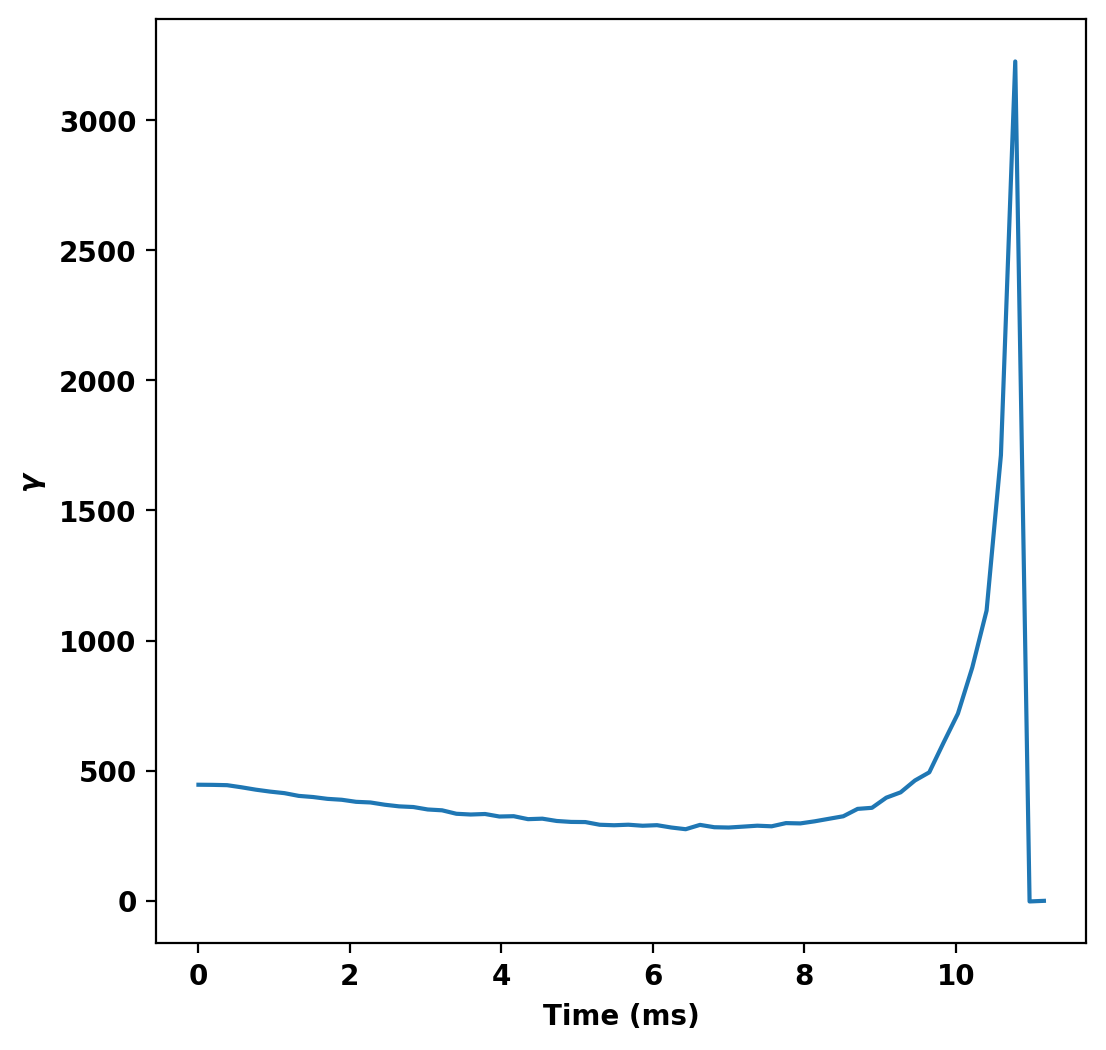

In [20]:
plt.plot(np.linspace(0,sim_time*1000, len(gammas)), gammas)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\gamma$')

/Applications/OpenFUSIONToolkit/python/OpenFUSIONToolkit/TokaMaker/_core.py:1132: UserWarning: No contour levels were found within the data range.
  ax.tricontour(self.r[:,0],self.r[:,1],self.lc,psi,levels=vacuum_levels,colors=vacuum_color,cmap=vacuum_colormap,linestyles=vacuum_linestyles)


Text(0, 0.5, 'Z (m)')

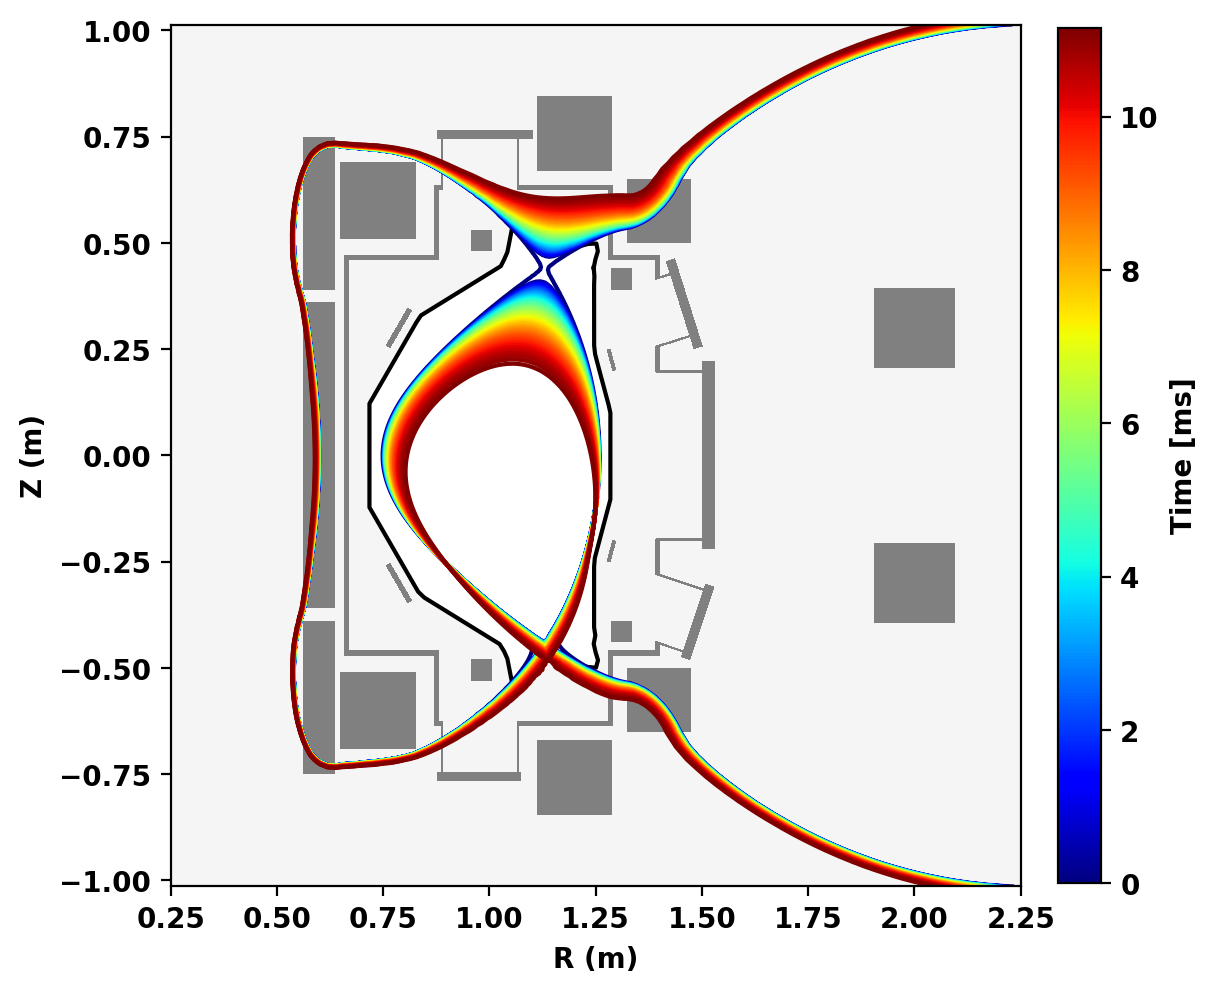

In [21]:
import matplotlib as mpl
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), ax = ax,label='Time [ms]',fraction=0.046, pad=0.04)
plt.xlim([0.25, 2.25])
plt.xlabel('R (m)')
plt.ylabel('Z (m)')